# Gene Scores

Gene score plots at a fine grained cluster level. Inputs:

1. `metadata.tsv` with UMAP/densMAP coordinates and total fragments/insertions.
2. Single-cell counts matrix derived from snapATAC with corresponding peaks.
3. Cluster assignment for each cell at high resolution (gene scores at pseudo-bulk).
4. GTF

In [1]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)
library(RColorBrewer)
library(DESeq2)
library(rtracklayer)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Loading Inputs

### MetaData

In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [4]:
# this is a kludge for now, clusters AND total insertions should also be present in same metaData as above
snapATAC_metaData = read.table("../analysis/20200122_snapATAC/snapATAC_sessions/20200518_n76052/metadata.tsv", header = T)
rownames(snapATAC_metaData) = paste(snapATAC_metaData$sample, snapATAC_metaData$barcode, sep='_')

metaData$cluster = snapATAC_metaData[rownames(metaData), "cluster"] 
metaData$total_insertions = snapATAC_metaData[rownames(metaData), "TN"] 
head(metaData)

,barcode,sample,umap1,umap2,cells,cluster,total_insertions
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<int>,<int>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC,5,53446
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT,5,27136
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC,5,23308
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG,6,18466
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA,5,3238
D0_AAACACGCTCGAGTGA,AAACACGCTCGAGTGA,D0,3.408866,-9.058377,D0_AAACACGCTCGAGTGA,6,50468


### Insertions Count Matrix + Regions

In [5]:
pmat = readMM("../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 409052

In [6]:
peak_regions = read.table("../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.bed")
names(peak_regions) = c("chr", "bp1", "bp2")
peak_regions$site_name <- paste(peak_regions$chr, peak_regions$bp1, peak_regions$bp2, sep="_")
row.names(peak_regions) <- peak_regions$site_name
dim(peak_regions)
head(peak_regions)

[1] 409052      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_10355_10867,chr1,10355,10867,chr1_10355_10867
chr1_41995_42521,chr1,41995,42521,chr1_41995_42521
chr1_46067_46593,chr1,46067,46593,chr1_46067_46593
chr1_48475_48975,chr1,48475,48975,chr1_48475_48975
chr1_51286_52235,chr1,51286,52235,chr1_51286_52235
chr1_58648_59148,chr1,58648,59148,chr1_58648_59148


In [7]:
peak_regions_gr =  GRanges(sub("_", "-", sub("_", ":", rownames(peak_regions))))

In [8]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), peak_regions_gr))])

[1] 12150

In [9]:
pmatRowSums = Matrix::rowSums(pmat)

In [14]:
# these values should correlate well (reads in peaks vs total reads)
cor(pmatRowSums, metaData$total_insertions, method='spearman')

[1] 0.9899533

### Fine Cluster Assignments

In [11]:
# load fine clusters from file
fine_clusters = read.table("../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/fine_clusters.tsv", 
            header = T)
all(fine_clusters$sample_barcode==rownames(metaData))

clusters = fine_clusters$clusters
head(fine_clusters)

[1] TRUE

,sample_barcode,clusters
,<fct>,<int>
1,D0_AAACAACGACGATTAC,26
2,D0_AAACAACGAGCGCACT,42
3,D0_AAACACGCTACGCCAC,42
4,D0_AAACACGCTAGTACGG,11
5,D0_AAACACGCTCCTCAAA,13
6,D0_AAACACGCTCGAGTGA,10


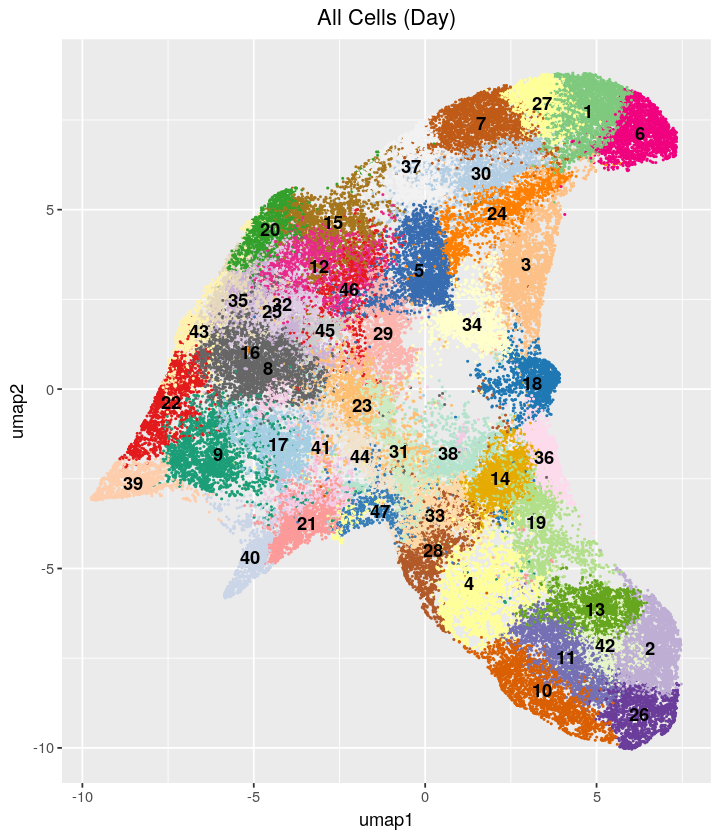

In [15]:
options(repr.plot.width = 6, repr.plot.height = 7)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                clst=as.factor(clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(metaData[,c("umap1","umap2")], 
                                    list(clusters), mean)),
         aes(x=umap1, y=umap2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

### Gene Set

In [16]:
gencode.basic.hg38 = import.gff(gzfile("../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 3)
length(gencode.basic.tx.hg38)

Warning message in readGFF(filepath, version = version, filter = filter):
“connection is not positioned at the start of the file, rewinding it”


GRanges object with 3 ranges and 21 metadata columns:
      seqnames        ranges strand |   source       type     score     phase
         <Rle>     <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1   65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1   69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
  [3]     chr1 450703-451697      - |   HAVANA transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
  [3] ENSG00000284733.1 protein_coding      OR4F29           2  HGNC:31275
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 

[1] 58073

In [17]:
tx.hg38 = gencode.basic.tx.hg38

In [18]:
tss.hg38 = unique(resize(tx.hg38, width=1, fix='start'))

In [19]:
prom.hg38 = promoters(tss.hg38, upstream = 100, downstream = 100)
head(prom.hg38, 2)

GRanges object with 2 ranges and 21 metadata columns:
      seqnames      ranges strand |   source       type     score     phase
         <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1 65319-65518      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1 68955-69154      + |  ENSEMBL transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 ENST00000641515.2  protein_coding       OR4F5-202
  [2] OTTHUMG00000001094.4 ENST00000335137.4  protein_coding       OR4F5-201
      transcript_support_level    

In [20]:
unique_prom_genes = names(table(prom.hg38$gene_name)[which(table(prom.hg38$gene_name)==1)])

## Compute Gene Scores

### Pseudo-bulk matrix

In [21]:
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(pmat)))

In [22]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) = sub("_", "-", sub("_", ":", rownames(peak_regions)))
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,⋯,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47
chr1:10355-10867,14,34,16,2,12,6,5,18,17,30,⋯,19,8,6,8,4,6,4,14,6,10
chr1:41995-42521,2,23,10,10,12,5,0,13,42,12,⋯,10,6,6,12,6,1,16,14,5,2
chr1:46067-46593,8,5,19,7,26,7,12,27,15,5,⋯,11,2,6,9,2,4,14,18,12,2
chr1:48475-48975,0,4,4,1,6,1,2,50,12,3,⋯,4,8,1,9,4,17,3,3,3,2
chr1:51286-52235,59,10,90,5,11,72,93,23,1,11,⋯,3,2,2,2,1,9,4,21,3,0
chr1:58648-59148,0,2,5,2,0,2,1,38,17,1,⋯,5,5,4,4,1,16,0,5,3,2


[1] 409052     47

In [23]:
cts = cts[rowSums(cts)>50, ]
dim(cts)

[1] 409051     47

In [24]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

### Inverse Distance Weighted Gene Score

In [25]:
distal_overlaps = findOverlaps(tss.hg38+100000, peak_regions_gr)
distal_overlaps

Hits object with 1949910 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1           1
        [2]         1           2
        [3]         1           3
        [4]         1           4
        [5]         1           5
        ...       ...         ...
  [1949906]     51887      409039
  [1949907]     51887      409040
  [1949908]     51900      409044
  [1949909]     51917      409048
  [1949910]     51918      409048
  -------
  queryLength: 51948 / subjectLength: 409052

In [26]:
distal_summed_gene = cts[subjectHits(distal_overlaps),]

gene_peak_coeff = 1000*(1+abs(mid(peak_regions_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

distal_summed_gene = aggregate(gene_peak_coeff * distal_summed_gene, list(queryHits(distal_overlaps)), sum)

# remove transcripts with duplicate entries (e.g. CD99-201 that is on chrY and chrX)
tx_names = prom.hg38[distal_summed_gene$Group.1]$transcript_name
distal_summed_gene = distal_summed_gene[!duplicated(tx_names), ]
rownames(distal_summed_gene) = tx_names[!duplicated(tx_names)]
distal_summed_gene$Group.1 = NULL

# only keep those with a peak at the TSS
# distal_summed_gene = distal_summed_gene[rownames(distal_summed_gene) %in% rownames(summed_gene), ]

# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/estimateSizeFactorsForMatrix(distal_summed_gene)))

head(distal_summed_gene, 2)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,⋯,cluster_38,cluster_39,cluster_40,cluster_41,cluster_42,cluster_43,cluster_44,cluster_45,cluster_46,cluster_47
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OR4F5-202,130.3095,35.64128,92.30022,33.18962,92.28145,175.6393,148.6189,103.24290,65.22417,24.92057,⋯,48.44362,55.08470,48.11984,68.44043,27.77580,141.4963,68.74271,63.18274,58.91463,35.53967
OR4F5-201,112.0703,29.56479,77.98841,28.59019,79.49076,149.4557,126.5507,78.80923,52.45056,21.47199,⋯,41.13844,43.05825,37.81589,53.59993,24.25446,105.3460,56.66019,53.22337,45.07329,30.73394


## Plotting

In [130]:
query = "^JAKMIP2-"
rownames(distal_summed_gene)[grepl(query, rownames(distal_summed_gene))]
GENE = rownames(distal_summed_gene)[grepl(query, rownames(distal_summed_gene))][3]

[1] "JAKMIP2-206" "JAKMIP2-205" "JAKMIP2-201" "JAKMIP2-202"

In [72]:
GENE="CDH1-201"

In [131]:
as.character(prom.hg38[prom.hg38$transcript_name==GENE]+1000)

[1] "chr5:147781676-147783875:-"

In [132]:
df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                distal_gene_score=as.numeric(distal_summed_gene[GENE, ])[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 25000), ]


gs_plot <- ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap1 , y=umap2, col=log2(1+distal_gene_score))) +
# ggtitle(sub("-2[0-9]+", "",GENE)) + 
scale_color_viridis_c(option = "D", name="Log2\nGene\nScore") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()

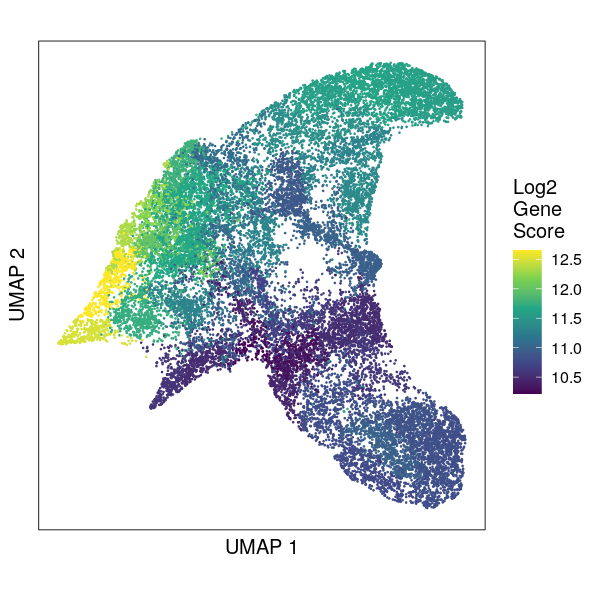

In [133]:
options(repr.plot.width = 5, repr.plot.height = 5)

gs_plot

In [134]:
saveRDS(gs_plot, file=sprintf("./Fig2/subfigs/%s_JAKMIP2_gs.rds",
                                   format(Sys.Date(), "%Y%m%d")))